In [1]:
import os
import glob
import random

import torch
import torchvision
import numpy as np
import cv2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
import torch.nn.functional as F

from IPython.display import Image

Подключаем cuda

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

device

'cuda'

## Датасет

Ссылка на датасет - https://www.kaggle.com/datasets/carlosrunner/pizza-not-pizza

Датасет состоит из изображений еды и изображений пиццы

Всего 2 класса.

Изображения изначально разных размеров, приведены изображения к одному размеру 100 на 100 пикселей

In [3]:
import os
import glob
import matplotlib.pyplot as plt

In [4]:
DATA_PATH = r'D:\ProgrammingPython\neural_networks\pizza_not_pizza_100'
classes = {n: cls for n,cls in enumerate(os.listdir(DATA_PATH))}
classes_invert = {value:key for key, value in classes.items() }

class PizzaDataset(Dataset):
    
    def __init__(self, rootdir, transform=None) -> None:
        super().__init__()
        self.class_names = os.listdir(rootdir)
        self.class_idx = [i for i in range(len(self.class_names))]
        self.transform = transform
        self.images_pathes = []
        self.images_clas_names = []

        for cls_name in self.class_names:
            sub_root = os.path.join(rootdir, cls_name)
            self.images_pathes.extend(glob.glob(os.path.join(sub_root, '*.jpg')))
            self.images_clas_names.append(cls_name)

        random.shuffle(self.images_pathes)
            
    def __len__(self):
        return len(self.images_pathes)
    
    def __getitem__(self, index) -> tuple:

        img_path = self.images_pathes[index]
        image = cv2.imread(img_path)
        img_folder_pth = os.path.split(img_path)[0]
        cls_name = os.path.split(img_folder_pth)[-1]
        label = self.class_names.index(cls_name)
        
        if self.transform:
           image = self.transform(image=image)["image"]

        return (image, label)

In [5]:
class TransformDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        image, label = self.subset[index]
        if self.transform:
            image = self.transform(image=image)["image"]
        return image, label
        
    def __len__(self):
        return len(self.subset)

In [6]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

album_transform = A.Compose([
    A.Flip(p=0.25),
    A.ElasticTransform(alpha=1.15, sigma=15, alpha_affine=10),
    A.GaussNoise(p=0.25),
    A.Blur(blur_limit=1),
    A.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5],
    ),
    ToTensorV2()
])

transform = transforms.Compose(
    [
        transforms.ToTensor(), 
        transforms.Normalize(mean = 0.5, std = 0.5)
    ]
)

simple_transform = A.Compose([
    A.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5],
    ),
    ToTensorV2()
])

In [7]:
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split

Оригинальный датасет не разделен на тренировочную и тестовую выборки, поэтому разделим датасет в соотношении 80 на 20

In [8]:
TEST_SIZE = 0.25
BATCH_SIZE = 64
SEED = 52

In [9]:
dataset = PizzaDataset(DATA_PATH)

In [10]:
generator = torch.Generator().manual_seed(SEED)

train_dataset, test_dataset = random_split(dataset, [1-TEST_SIZE, TEST_SIZE], generator=generator)

In [11]:
train_modified_dataset = TransformDataset(train_dataset, album_transform)
test_modified_dataset = TransformDataset(test_dataset, simple_transform)

In [12]:
train_loader = DataLoader(train_modified_dataset, batch_size=BATCH_SIZE)

test_loader = DataLoader(test_modified_dataset, batch_size=BATCH_SIZE)

In [13]:
for x,y in train_loader:
    print(x.shape)
    print(y)
    break


torch.Size([64, 3, 100, 100])
tensor([1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
        1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
        0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1])


In [14]:
def plot_imgs(data_loader):
    plt.rcParams.update({'font.size': 10})
    fig = plt.figure(figsize=(5, 5))
    columns = 2
    rows = 2
    for i in range(columns*rows):
        for x, y in data_loader:
            img = (x[i].numpy().transpose(1, 2, 0) + 1) / 2
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            a = fig.add_subplot(rows, columns, i+1)
            plt.axis('off')
            plt.imshow((img*255).astype('int32'))
            a.set_title(classes[int(y[i])])
            break
    plt.show()

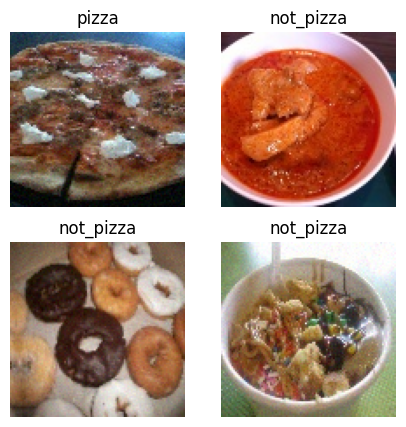

In [15]:
plot_imgs(train_loader)

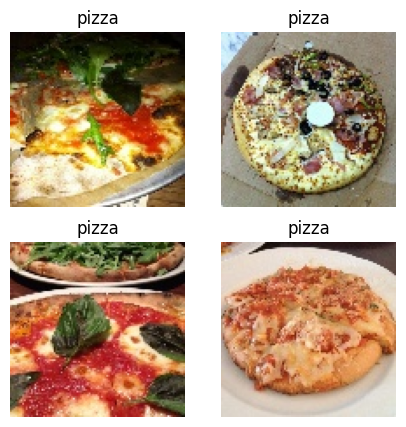

In [16]:
plot_imgs(test_loader)

## Модель

In [17]:
# выход с последнего слоя
print(f"Кол-во классов: {len(classes.values())}")

Кол-во классов: 2


Имеем входной тензор 100 на 100.

Вычисляем кол-во нейронов на полносвязном слое.

(100 - 3 + 1) // 2 = 49

(49 - 3 + 1 - 3 + 1 - 3 + 1) // 2 = 21

(21 - 3 + 1) // 2 = 9

64 * 9 * 9 = 5184

In [18]:
class PizzaClassificator(nn.Module):
    def __init__(self):
        super(PizzaClassificator, self).__init__()
        self.conv_1 = nn.Conv2d(3, 8, (3,3), 1)
        self.avPoll_1 = nn.AvgPool2d((2,2), 2)
        self.conv_2 = nn.Conv2d(8, 16, (3,3), 1)
        self.conv_3 = nn.Conv2d(16, 16, (3,3), 1)
        self.conv_4 = nn.Conv2d(16, 32, (3,3), 1)
        self.avPoll_2 = nn.AvgPool2d((2,2), 2)
        self.conv_5 = nn.Conv2d(32, 64, (3,3), 1)
        self.avPoll_3 = nn.AvgPool2d((2,2), 2)
        self.linear_1 = nn.Linear(64 * 9 * 9, 512)
        self.linear_2 = nn.Linear(512, 2)


    def forward(self, x):
        x = self.conv_1(x)
        x = F.tanh(x)
        x = self.avPoll_1(x)
        x = F.tanh(x)

        x = self.conv_2(x)
        x = F.tanh(x)
        x = self.conv_3(x)
        x = F.tanh(x)
        x = self.conv_4(x)
        x = F.tanh(x)
        x = self.avPoll_2(x)
        x = F.tanh(x)

        x = self.conv_5(x)
        x = F.tanh(x)
        x = self.avPoll_3(x)
        x = F.tanh(x)

        x = torch.flatten(x, start_dim=1)

        x = self.linear_1(x)
        x = F.tanh(x)
        x = self.linear_2(x)
        
        return x

In [19]:
class CSPBlock(nn.Module):
    def __init__(self, input_channel):
        super(CSPBlock, self).__init__()
        self.conv_1 = nn.Conv2d(input_channel//2, input_channel//2, (1,1), 1, padding = 0)
        self.conv_3 = nn.Conv2d(input_channel//2, input_channel//2, (3,3), 1, padding = 1)

    def forward(self, x):
        in_chanel = x.size(1)
        x1 = x[:,:in_chanel//2, :, :]
        x2 = x[:,in_chanel//2:, :, :]
        x1 = self.conv_1(x1)
        x1 = F.tanh(x1)
        x1 = self.conv_3(x1)
        x1 = F.tanh(x1)
        x = torch.cat((x1, x2),dim=1)

        return x

In [20]:
class PizzaClassificator_CSP(nn.Module):
    def __init__(self):
        super(PizzaClassificator_CSP, self).__init__()
        self.conv_1 = nn.Conv2d(3, 8, (3,3), 1)
        self.csp_1 = CSPBlock(8)
        self.avPoll_1 = nn.AvgPool2d((2,2), 2)
        self.conv_2 = nn.Conv2d(8, 16, (3,3), 1)
        self.conv_3 = nn.Conv2d(16, 16, (3,3), 1)
        self.conv_4 = nn.Conv2d(16, 32, (3,3), 1)
        self.csp_2 = CSPBlock(32)
        self.avPoll_2 = nn.AvgPool2d((2,2), 2)
        self.conv_5 = nn.Conv2d(32, 64, (3,3), 1)
        self.csp_3 = CSPBlock(64)
        self.avPoll_3 = nn.AvgPool2d((2,2), 2)
        self.linear_1 = nn.Linear(64 * 9 * 9, 512)
        self.linear_2 = nn.Linear(512, 2)

    def forward(self, x):

        x = self.conv_1(x)
        x = F.tanh(x)
        x = self.csp_1(x)
        x = self.avPoll_1(x)

        x = self.conv_2(x)
        x = F.tanh(x)
        x = self.conv_3(x)
        x = F.tanh(x)
        x = self.conv_4(x)
        x = F.tanh(x)
        x = self.csp_2(x)
        x = self.avPoll_2(x)
        x = F.tanh(x)

        x = self.conv_5(x)
        x = F.tanh(x)
        x = self.csp_3(x)
        x = self.avPoll_3(x)
        x = F.tanh(x)

        x = torch.flatten(x, start_dim=1)

        x = self.linear_1(x)
        x = F.tanh(x)
        x = self.linear_2(x)
        
        return x

In [21]:
model = PizzaClassificator_CSP()
model.to(device)
loss_function = torch.nn.CrossEntropyLoss()

optimizator = torch.optim.Adam(model.parameters(), lr=0.0001,)

In [22]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [23]:
def val(model, test_loader):
    model.eval()
    tp = 0
    total = 0

    for x,y in test_loader:
        y = y.to(device)
        pred = torch.argmax(model(x.to(device)), dim=1)
        tp += int((pred == y).sum().to('cpu'))
        total +=len(pred)
    
    return tp/total

def train(dataloader, model, loss_fn, op_fn, epoch):
    acc = 0
    loss = 0
    total_test_loss = 0
    scheduler = ReduceLROnPlateau(op_fn, 'min')
    for ep in range(epoch):
        print("epoch: ", ep+1)
        for step, (x, y) in enumerate(dataloader):
            y_pred = model(x.to(device))
            loss = loss_fn(y_pred.to(device), y.to(device))

            op_fn.zero_grad()
            loss.backward()
            op_fn.step()

            if step%100 == 0:
                loss, current = loss.item(), (ep+1)*(step+1)*BATCH_SIZE

        acc = val(model, test_loader)
        print(f"loss = {loss}")
        print('accuracy =', acc)

        scheduler.step(loss)


    return acc


In [24]:
accuracy = train(train_loader, model, loss_function, optimizator, 10)

epoch:  1


d:\ProgrammingPython\neural_networks\.conda\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


loss = 0.68027263879776
accuracy = 0.6578411405295316
epoch:  2
loss = 0.6575893759727478
accuracy = 0.6741344195519349
epoch:  3
loss = 0.7256333827972412
accuracy = 0.6904276985743381
epoch:  4
loss = 0.5828050374984741
accuracy = 0.7006109979633401
epoch:  5
loss = 0.5787625908851624
accuracy = 0.7046843177189409
epoch:  6
loss = 0.49743416905403137
accuracy = 0.7006109979633401
epoch:  7
loss = 0.6108382940292358
accuracy = 0.6945010183299389
epoch:  8
loss = 0.5273476839065552
accuracy = 0.7169042769857433
epoch:  9
loss = 0.562321662902832
accuracy = 0.7128309572301426
epoch:  10
loss = 0.49673327803611755
accuracy = 0.7067209775967414


Сохраним модель, указав датасет, кол-во эпох и точность

In [25]:
accuracy = (accuracy*100)
output_str = f"pizza_100_csp_classifier_10_{accuracy:.2f}"
output_str = output_str.replace(".", "_")
output_str = output_str + '.pt'
print(output_str)

pizza_100_csp_classifier_10_70_67.pt


In [26]:
torch.save(model, output_str)

## Оценка модели

In [27]:
model.to('cpu')
model(x).size()

torch.Size([64, 2])

In [28]:
model.eval()

PizzaClassificator_CSP(
  (conv_1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (csp_1): CSPBlock(
    (conv_1): Conv2d(4, 4, kernel_size=(1, 1), stride=(1, 1))
    (conv_3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (avPoll_1): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (conv_2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv_3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv_4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (csp_2): CSPBlock(
    (conv_1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (conv_3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (avPoll_2): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (conv_5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (csp_3): CSPBlock(
    (conv_1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (conv_3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (avPoll_3): AvgPool2d(kernel_size=

In [29]:
predicts = []
labels = []

for x,y in test_loader:
    y = y.to('cpu').numpy()
    pred = torch.argmax(model(x.to('cpu')), dim=1).to('cpu').numpy()
    predicts.append(pred)
    labels.append(y)

print(len(predicts))


8


Посмотрим ответы модели

С помощью num_in_batch выбираем картинку в первом batch

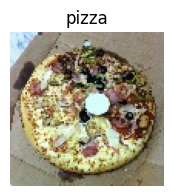

Истинная метка: 1 - pizza
Предсказ метка: 1 - pizza


In [30]:
num_in_batch = 1
for x,y in test_loader:
    # Преобразование значений изображения из диапазона [-1, 1] в диапазон [0, 1]
    img = (x[num_in_batch].numpy().transpose(1, 2, 0) + 1) / 2
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(2, 2))
    plt.axis('off')
    # Преобразование значений изображения из диапазона [0, 1] в диапазон [0, 255] (Перемешались цвет. каналы)
    plt.imshow((img*255).astype('int32'))
    plt.title(classes[int(y[num_in_batch])])
    plt.show()
    print(f'Истинная метка: {y[num_in_batch].numpy()} - {classes[int(y[num_in_batch])]}')
    print(f'Предсказ метка: {predicts[0][num_in_batch]} - {classes[int(predicts[0][num_in_batch])]}')
    break

In [31]:
predicts = np.concatenate(predicts)
labels = np.concatenate(labels)

In [32]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

Посчитаем метрики: Accuracy, Precision, recall. Посчитаем для каждого класса в бинарном виде каждую метрику и возьмём среднее.

In [33]:
print(f"Accuracy = {accuracy_score(labels, predicts)}",
    f"\nPrecision = {precision_score(labels, predicts, average=None, zero_division=0).mean()}",
    f"\nRecall = {recall_score(labels, predicts, average=None).mean()}")

Accuracy = 0.7067209775967414 
Precision = 0.706649077392805 
Recall = 0.7066970954356846


In [34]:
cm = confusion_matrix(labels, predicts, labels=tuple(classes.keys()))

In [35]:
cm.shape

(2, 2)

In [36]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

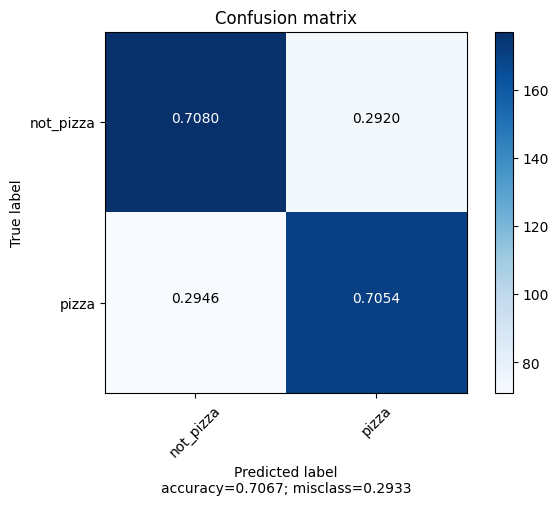

In [37]:
plot_confusion_matrix(cm, tuple(classes.values()))